## This notebook shows an example where a set of electrodes are selected from a dataset and then LFP is extracted from those electrodes and written to a new NWB file


### We assume that you have added an NWB file to the database (see Populate_from_NWB_tutorial notebook)

#### Load all of the relevant modules and set the environment variables. 
Note that the datadir and datadir/analysis must exist

In [1]:
%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
%load_ext autoreload
%autoreload 2

import pynwb
import os

# DataJoint and DataJoint schema
import datajoint as dj

# the commands below can be run once to update your global configuration
#dj.config["enable_python_native_blobs"] = True
#dj.config["database.user"] = 'root'
#dj.config["database.password"] = 'tutorial'
#dj.config.save_global()

import nwb_datajoint as nd
import ndx_franklab_novela.probe

import warnings
warnings.simplefilter('ignore')

# Note that all of the following must exist
data_dir = '/Users/loren/data/nwb_builder_test_data'  # CHANGE ME
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir
os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')
os.environ['SPIKE_SORTING_STORAGE_DIR'] = os.path.join(data_dir, 'spikesorting')

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@localhost:3306


#### Next we select the NWB file, which corresponds to the dataset we want to extract LFP from

In [2]:
nwb_file_names = nd.common.Nwbfile().fetch('nwb_file_name')
# take the first one for this demonstration
nwb_file_name = nwb_file_names[0]
print(nwb_file_name)

beans20190718-trim.nwb


#### Create the standard LFP Filters. This only needs to be done once.

In [3]:
nd.common.FirFilter().create_standard_filters()

### Select every 16th electrode for LFP

In [4]:
electrode_ids = nd.common.Electrode.fetch('electrode_id')
lfp_electrode_ids = electrode_ids[range(0, len(electrode_ids), 16)]
nd.common.LFPSelection().set_lfp_electrodes(nwb_file_name, lfp_electrode_ids.tolist())

About to delete:
`common_ephys`.`__l_f_p_band`: 1 items
`common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`: 3 items
`common_ephys`.`l_f_p_band_selection`: 1 items
`common_ephys`.`_l_f_p`: 1 items
`common_ephys`.`l_f_p_selection__l_f_p_electrode`: 16 items
`common_ephys`.`l_f_p_selection`: 1 items


Proceed? [yes, No]:  yes


Committed.


Show the list of selected electrodes. Note that the electrode_group corresponds to the physical probe the electrode was part of.

In [5]:
nd.common.LFPSelection().LFPElectrode()

nwb_file_name the name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
beans20190718-trim.nwb,0,0
beans20190718-trim.nwb,0,16
beans20190718-trim.nwb,0,32
beans20190718-trim.nwb,0,48
beans20190718-trim.nwb,0,64
beans20190718-trim.nwb,0,80
beans20190718-trim.nwb,0,96
beans20190718-trim.nwb,0,112
beans20190718-trim.nwb,1,128
beans20190718-trim.nwb,1,144


### Populate the LFP table

In [6]:
nd.common.LFP().populate()

writing new NWB file beans20190718-trim_00000004.nwb
Output array should have shape (200000, 16) and dtype <f8
Checking output array shape is disabled, make sure portion of output array has shape (200000, 16)


### Now that we've created the LFP object we can perform a second level of filtering for a band of interest, in this case the theta band
We first need to create the filter

In [7]:
lfp_sampling_rate = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch1('lfp_sampling_rate')
filter_name = 'Theta 5-11 Hz'
nd.common.FirFilter().add_filter(filter_name, lfp_sampling_rate, 'bandpass', [4, 5, 11, 12], 'theta filter for 1 KHz data')

In [8]:
nd.common.FirFilter()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,30000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
Theta 5-11 Hz,1000,lowpass,4.0,5.0,11.0,12.0,theta filter for 1 Khz data,=BLOB=,=BLOB=


Next we add an entry for the LFP Band and the electrodes we want to filter

In [9]:
# assume that we've filtered these electrodes; change this if not
lfp_band_electrode_ids = [0, 16, 32]

# set the interval list name corresponding to the first epoch (a sleep session)
interval_list_name = '01_s1'

# set the reference to -1 to indicate no reference for all channels
ref_elect = [-1]

# desired sampling rate
lfp_band_sampling_rate = lfp_sampling_rate // 10

In [10]:
(nd.common.IntervalList() & {'nwb_file_name' : nwb_file_name, 'interval_list_name': interval_list_name}).fetch1('valid_times')[0, 1]

1563489188.87307

In [11]:
nd.common.LFPBandSelection().set_lfp_band_electrodes(nwb_file_name, lfp_band_electrode_ids, filter_name, interval_list_name, ref_elect, lfp_band_sampling_rate)

Check to make sure it worked

In [12]:
nd.common.LFPBandSelection()

nwb_file_name the name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band
beans20190718-trim.nwb,Theta 5-11 Hz,1000,01_s1,100


In [13]:
nd.common.LFPBandSelection().LFPBandElectrode()

nwb_file_name the name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
beans20190718-trim.nwb,Theta 5-11 Hz,1000,0,0,-1
beans20190718-trim.nwb,Theta 5-11 Hz,1000,0,16,-1
beans20190718-trim.nwb,Theta 5-11 Hz,1000,0,32,-1


In [14]:
(nd.common.LFP()& {'nwb_file_name' : nwb_file_name}).fetch_nwb()

[{'nwb_file_name': 'beans20190718-trim.nwb', 'analysis_file_name': 'beans20190718-trim_00000004.nwb', 'interval_list_name': 'raw data valid times', 'filter_name': 'LFP 0-400 Hz', 'filter_sampling_rate': 20000, 'lfp_object_id': 'ba029d4d-6716-467b-a1cc-2ff26f788e38', 'lfp_sampling_rate': 1000.0, 'nwb2load_filepath': '/Users/loren/data/nwb_builder_test_data/analysis/beans20190718-trim_00000004.nwb'}]


[{'nwb_file_name': 'beans20190718-trim.nwb',
  'analysis_file_name': 'beans20190718-trim_00000004.nwb',
  'interval_list_name': 'raw data valid times',
  'filter_name': 'LFP 0-400 Hz',
  'filter_sampling_rate': 20000,
  'lfp_object_id': 'ba029d4d-6716-467b-a1cc-2ff26f788e38',
  'lfp_sampling_rate': 1000.0,
  'lfp': filtered data pynwb.ecephys.ElectricalSeries at 0x140450135078560
  Fields:
    comments: no comments
    conversion: 1.0
    data: <HDF5 dataset "data": shape (200000, 16), type "<i2">
    description: no description
    electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
    interval: 1
    resolution: -1.0
    timestamps: <HDF5 dataset "timestamps": shape (200000,), type "<f8">
    timestamps_unit: seconds
    unit: volts}]

In [15]:
nd.common.LFPBand().populate()

[{'nwb_file_name': 'beans20190718-trim.nwb', 'analysis_file_name': 'beans20190718-trim_00000004.nwb', 'interval_list_name': 'raw data valid times', 'filter_name': 'LFP 0-400 Hz', 'filter_sampling_rate': 20000, 'lfp_object_id': 'ba029d4d-6716-467b-a1cc-2ff26f788e38', 'lfp_sampling_rate': 1000.0, 'nwb2load_filepath': '/Users/loren/data/nwb_builder_test_data/analysis/beans20190718-trim_00000004.nwb'}]
writing new NWB file beans20190718-trim_00000005.nwb
Output array should have shape (20000, 3) and dtype <f8
Checking output array shape is disabled, make sure portion of output array has shape (20000, 3)


### Now we can plot the original signal, the LFP filtered trace, and the theta filtered trace together.
Much of the code below could be replaced by a function calls that would return the data from each electrical series, or better yet, plot the data in an electrical series.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
#get the three electrical series objects and the indeces of the electrodes we band pass filtered
orig_eseries = (nd.common.Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw']
orig_elect_indeces = nd.common.get_electrode_indeces(orig_eseries, lfp_band_electrode_ids)

lfp_eseries = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp']
lfp_elect_indeces = nd.common.get_electrode_indeces(lfp_eseries, lfp_band_electrode_ids)

lfp_band_eseries = (nd.common.LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']
lfp_band_elect_indeces = nd.common.get_electrode_indeces(lfp_band_eseries, lfp_band_electrode_ids)

[{'nwb_file_name': 'beans20190718-trim.nwb', 'interval_list_name': 'raw data valid times', 'raw_object_id': 'b03547f7-7f3c-4d5b-ad9a-0beb267c8992', 'sampling_rate': 20000.0, 'comments': 'no comments', 'description': 'Electrical series registered on electrode', 'nwb2load_filepath': '/Users/loren/data/nwb_builder_test_data/beans20190718-trim.nwb'}]
[{'nwb_file_name': 'beans20190718-trim.nwb', 'analysis_file_name': 'beans20190718-trim_00000004.nwb', 'interval_list_name': 'raw data valid times', 'filter_name': 'LFP 0-400 Hz', 'filter_sampling_rate': 20000, 'lfp_object_id': 'ba029d4d-6716-467b-a1cc-2ff26f788e38', 'lfp_sampling_rate': 1000.0, 'nwb2load_filepath': '/Users/loren/data/nwb_builder_test_data/analysis/beans20190718-trim_00000004.nwb'}]
[{'nwb_file_name': 'beans20190718-trim.nwb', 'filter_name': 'Theta 5-11 Hz', 'filter_sampling_rate': 1000, 'analysis_file_name': 'beans20190718-trim_00000005.nwb', 'filtered_data_object_id': '9c4a170f-53b8-4e51-8b14-3038b8a1e9fe', 'nwb2load_filepath

In [21]:
# get a list of times for the first run epoch and then select a 1 second interval 100 seconds from the beginning
times = (nd.common.IntervalList & {'interval_list_name' : interval_list_name}).fetch1('valid_times')
plottimes = [times[0][0] + 101, times[0][0] + 102]

In [22]:
# get the time indeces for each dataset
orig_time_ind = np.argwhere(np.logical_and(orig_eseries.timestamps > plottimes[0], orig_eseries.timestamps < plottimes[1]))
lfp_time_ind = np.argwhere(np.logical_and(lfp_eseries.timestamps > plottimes[0], lfp_eseries.timestamps < plottimes[1]))
lfp_band_time_ind = np.argwhere(np.logical_and(lfp_band_eseries.timestamps > plottimes[0], lfp_band_eseries.timestamps < plottimes[1]))

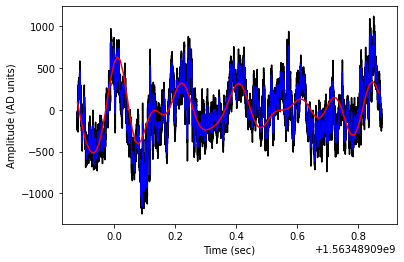

In [23]:
plt.plot(orig_eseries.timestamps[orig_time_ind], orig_eseries.data[orig_time_ind,orig_elect_indeces[1]], 'k-')
plt.plot(lfp_eseries.timestamps[lfp_time_ind], lfp_eseries.data[lfp_time_ind,lfp_elect_indeces[1]], 'b-')
plt.plot(lfp_band_eseries.timestamps[lfp_band_time_ind], lfp_band_eseries.data[lfp_band_time_ind,lfp_band_elect_indeces[1]], 'r-')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (AD units)')

plt.show()